# **Exploratory Data Analysis on Twitter Sentiment Analysis dataset**

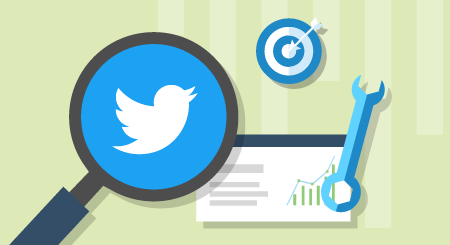

By :  <a href="https://www.linkedin.com/in/bala-murugan-62073b212/">Balamurugan P

# **Introduction**

The task is to squeeze out as much insights as possible from just a single feature (tweets).

The dataset contains tweets categorized as "Offensive (racism/sexism)" labelled as 1 and "Not offensive" labelled as 0.

This dataset contains around 50k tweets split into training and testing data.


Analysis was done using,
* *Different kinds of visualizations like pie chart, bar chart, box plot etc.*
* *Creating Word clouds.*
* *Extracting information from hashtags.*
* *Named Entity Recognition.*

# **Let's import the dependancies**

In [ ]:
# Importing modules
import re
import pandas as pd
import spacy
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# Setting to use seaborn style for plots
matplotlib.style.use("seaborn")

# **Let's load our data**

In [ ]:
# Loading data
train = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/train.csv")
test = pd.read_csv("../input/twitter-sentiment-analysis-hatred-speech/test.csv")

# **Exploring DataFrames**

*Let's explore some rows of our DataFrames and check their schema.*

In [ ]:
# Displaying sample obervations
display(train.head())
display(test.head())

In [ ]:
# Label encodings
labels = {0: "not offensive", 1: "offensive"}
print(labels)

In [ ]:
display(train.info())

In [ ]:
display(test.info())

* The dataset contains three columns - "id", "label", "tweet"
* Column "id" is not useful for classification.
* Column "tweet" contains the tweets and column "label" contains their category.
* There is no null values.

# **Checking the distribution of categories**

*Let's check how much data falls under each category.*

In [ ]:
# Visualising distribution of observations among categories

plt.figure(figsize=(6, 6))

# Creates pie chart
plt.pie(
    train["label"].value_counts(),
    autopct = "%.2f%%",
    labels = ["Not Offensive", "Offensive"],
    colors = ["#00ff00", "#ff0000"]
)

# Creates circle
circle = plt.Circle((0,0), 0.80,fc='white')

# Adds circle object to the existing figure (pie chart)
fig = plt.gcf()
fig.gca().add_artist(circle)

plt.show()

* Offensive tweets which reflects racism or sexism are relatively lesser in number.
* Due to this class imbalance, Accuracy may not be a good option for checking performance of our models. Instead, confusion matrix can be a good option.

# **Now, we can have a look at length of each tweets**

*Knowing the max number of words in the dataset will be helpful later.*

In [ ]:
# Plotting histogram for number of tokens in each observation
ax1 = train.tweet.str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
ax1.set(xlabel="( Number of Tokens )", ylabel="( Number of Observations )")

* Most of the tweets have around 5 to 20 tokens.

*Let's look a bit deeper.*

In [ ]:
# Plotting boxplot for number of tokens in each observation
ax2 = train.tweet.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
ax2.set_ylabel("( Number of Tokens )")

* The number of tokens between 25th and 75th %ile (Interquartile range) of data ranges from 9 to 17 tokens, median being 13 tokens.
* Max length of any tweet in the dataset is less than 35 tokens.

# **Preprocessing tweets and creating word corpus**

*Word corpus is helpful for analysing data and useful for Named entity recognition, creating word clouds etc...*

In [ ]:
def preprocess_tweets(df_series):
    """ Removes account tags (@user) and all non-alphanumeric characters except whitespace.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        
    Returns: 
        df_series (pd.series): Preprocessed series object. 
    """
    
    # Removes '@user' tags
    df_series = df_series.str.replace("@user", "", regex=False)
    
    # Removes non alphanumeric characters
    df_series = df_series.str.replace("[^a-zA-Z0-9 ]", " ")
    return df_series
    

def tokenize(sentence, remove_stopwords=False):
    """ Tokenizes given sentence.
        
    Args:
        sentence (str): Sentence to be tokenized
        remove_stopwords (bool): removes stop words if set True. Defaults to False.
        
    Returns: 
        tokens (list): Tokenized array
    """
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = sentence.split()
        tokens = [token for token in tokens if not token.lower() in stop_words]
        return tokens
        
    return sentence.split()
    

def create_corpus(df_series, remove_stopwords=False):
    """ Creates preprocessed, lemmatized word corpus from pandas series.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        remove_stopwords (bool): removes stop words if set True. Defaults to False.
        
    Returns: 
        corpus (list): Tokenized, Lemmatized word corpus. 
    """
    
    corpus = []
    lm = WordNetLemmatizer()
    df_series = preprocess_tweets(df_series)
    
    for tweet in df_series:
        corpus.extend([lm.lemmatize(word) for word in tokenize(tweet, remove_stopwords=remove_stopwords)])
    
    return corpus
    

offensive_corpus = create_corpus(train[train["label"]==1].tweet, remove_stopwords=True)
non_offensive_corpus = create_corpus(train[train["label"]==0].tweet, remove_stopwords=True)

# **Creating word cloud from our corpus**

*Word cloud shows the highly frequent words*

In [ ]:
def plot_word_cloud(corpus):
    """ Creates and plots the word cloud from word corpus.
        
    Args:
        corpus (list): word corpus containing all the tokens.
        
    Returns: Nothing
    
    """
    
    # creates word cloud
    word_cloud = WordCloud(
        max_words = 100,
        max_font_size = 50,
        collocations = False
    ).generate(str(corpus))
    
    # plots word cloud
    fig = plt.figure(figsize=(13, 13))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.plot()

In [ ]:
# Word cloud of non-offensive tokens
plot_word_cloud(non_offensive_corpus)

In [ ]:
# Word cloud of offensive tokens
plot_word_cloud(offensive_corpus)

* We can clearly see the words like "racist", "black", "hate", "race" which reflects offensiveness. Which were not present in the case of non-offensive corpus.

# **Finding named entity for all the words in our tweets data**

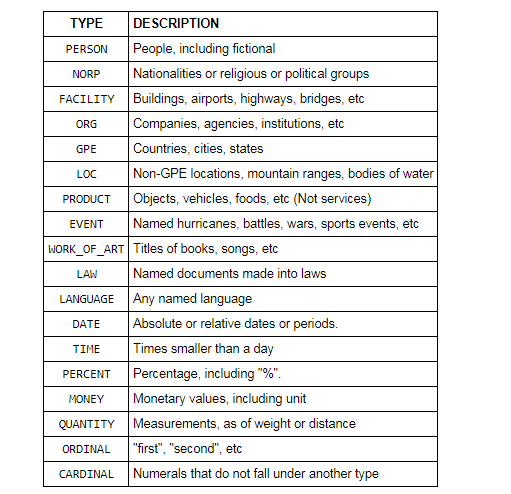

*To check what the offensive and non-offensive tweets talks about the most*

In [ ]:
def create_ner_dict(df_series):
    """ Creates and returns dictionary having text phrases and their named entity.
    
    Args:
        df_series (pd.series): Pandas series object containing sentences.
    
    Returns:
        NER_dict (dict): Dictionary of text phrases from sentences of df_series and 
                         corresponding named entities.
    """
    
    NER = spacy.load("en_core_web_sm")
    NER_dict = {"text": [], "named_entity":[]}
    
    # Preprocessing tweets
    preprocessed_tweets = preprocess_tweets(df_series)
    
    # Removing stop words and creating named entity recognition dict
    for tweet in preprocessed_tweets:
        sentence = tokenize(tweet, remove_stopwords=True)
        sentence = ' '.join(map(str, sentence))
        doc = NER(sentence)
        NER_dict["text"].extend([token.text for token in doc.ents])
        NER_dict["named_entity"].extend([token.label_ for token in doc.ents])
        
    return NER_dict

In [ ]:
# Named entity recognition of tweets of different categories
non_offensive_NER_dict = create_ner_dict(train[train["label"]==0].tweet)
offensive_NER_dict = create_ner_dict(train[train["label"]==1].tweet)

In [ ]:
# Converting to DataFrame
non_offensive_NER_df = pd.DataFrame.from_dict(non_offensive_NER_dict)
offensive_NER_df = pd.DataFrame.from_dict(offensive_NER_dict)

In [ ]:
# Displaying sample observations
display(non_offensive_NER_df.head())
display(offensive_NER_df.head())

# **Visualizes frequency of each named entities in our data**

In [ ]:
# Plotting named entities mentioned most times in Non-Offensive tweets
non_offensive_NER_df.groupby("named_entity").agg({"text": pd.Series.nunique}).plot.barh(figsize=(8,11))

In [ ]:
# Plotting named entities mentioned most times in Offensive tweets
offensive_NER_df.groupby("named_entity").agg({"text": pd.Series.nunique}).plot.barh(figsize=(8,11))

* From the visualisation we can infer that most of the times tweets are about a specific person or an organisation.
* Offensiveness in tweets also targets a specific person, organisation, nationalities, religious or political groups.

# **Finding most repeated text phrases under each named entity**

*Let's find and visualize highly frequent text phrases grouped by each named entity.*

In [ ]:
# Creates new df containing count of text by each named entity of Non offensive tweets
non_offensive_NER_text_occurances = non_offensive_NER_df.groupby("named_entity").agg({"text": list})
non_offensive_NER_text_occurances["text_counts"] = non_offensive_NER_text_occurances.agg({"text": Counter})["text"]

In [ ]:
display(non_offensive_NER_text_occurances)

In [ ]:
# Creates new df containing count of text by each named entity of Offensive tweets
offensive_NER_text_occurances = offensive_NER_df.groupby("named_entity").agg({"text": list})
offensive_NER_text_occurances["text_counts"] = offensive_NER_text_occurances.agg({"text": Counter})["text"]

In [ ]:
def sort_dict_by_value(dictionary, reverse=False):
    """ Returns list of (value, key) tuples sorted by value.
    
    Args:
        dictionary (dict): Dict of key, value pairs.
        reverse (bool): Sorts in descending order if set True. Defaults to False
        
    Returns:
        list: Contains (value, key) tuples sorted by value
    """
    
    return sorted(
        dict((value, key) for (key, value) in dictionary.items()).items(),
        reverse=reverse
    )


def max_val_of_dict(dictionary):
    """ Returns list containing maximum value and its corresponding 
        key in a dict.
        
    Args:
        dictionary (dict): Dict of key, value pairs.
            
    Returns:
        list: Contains corresponding key of maximum value in the dictionary
              and the maximum value itself.
    """
    
    max_key = max(dictionary, key=dictionary.get)
    max_value = dictionary[max_key]
    
    return [max_key, max_value]

In [ ]:
# displays highest repeated text by each named entity in Non offensive tweets
n_rows, n_cols = non_offensive_NER_text_occurances.shape

for i in range(n_rows):
    non_offensive_NER_text_occurances["text_counts"][i] = sort_dict_by_value(
                                                                non_offensive_NER_text_occurances["text_counts"][i],
                                                                reverse=True
                                                            )

non_offensive_NER_text_occurances.reset_index(inplace=True)
display(non_offensive_NER_text_occurances)

In [ ]:
# displays highest repeated text by each named entity in Offensive tweets
n_rows, n_cols = offensive_NER_text_occurances.shape

for i in range(n_rows):
    offensive_NER_text_occurances["text_counts"][i] = sort_dict_by_value(
                                                                offensive_NER_text_occurances["text_counts"][i],
                                                                reverse=True
                                                            )

offensive_NER_text_occurances.reset_index(inplace=True)

display(offensive_NER_text_occurances)

In [ ]:
# These are the named entities that we want to explore further
req_entities = ["EVENT", "GPE", "LANGUAGE", "NORP", "ORG"]
n_req_entities = len(req_entities)

In [ ]:
# Visualizes most repetetive Non offensive text phrases from each named entity
fig1, ax3 = plt.subplots(n_req_entities, constrained_layout=True, figsize=(10, 12))
fig1.suptitle("Frequent text (Non offensive) grouped by each entity\n(y-axis: Text phrase; x-axis: Count)", fontsize=20)

for i in range(n_req_entities):
    x, yticklabels = list(zip(
                        *non_offensive_NER_text_occurances[non_offensive_NER_text_occurances["named_entity"] == req_entities[i]]["text_counts"].values[0][:5]))
    ax3[i].barh(yticklabels, x, color='green')
    ax3[i].set_title("Entity: " + req_entities[i], fontsize=15)
    ax3[i].tick_params(labelsize=12)
    ax3[i].invert_yaxis()

In [ ]:
# Visualizes most repetetive Offensive text phrases from each named entity
fig2, ax4 = plt.subplots(n_req_entities, constrained_layout=True, figsize=(10, 12))
fig2.suptitle("Frequent text (Offensive) grouped by each entity\n(y-axis: Text phrase; x-axis: Count)", fontsize=20)

for i in range(n_req_entities):
    x, yticklabels = list(zip(
                        *offensive_NER_text_occurances[offensive_NER_text_occurances["named_entity"] == req_entities[i]]["text_counts"].values[0][:5]))
    ax4[i].barh(yticklabels, x, color='crimson')
    ax4[i].set_title("Entity: " + req_entities[i], fontsize=15)
    ax4[i].tick_params(labelsize=12)
    ax4[i].invert_yaxis()

* From the visualisations we can see the most frequent words grouped by each named entity across categories.

# **Visualizing top mentioned hashtags under each category**

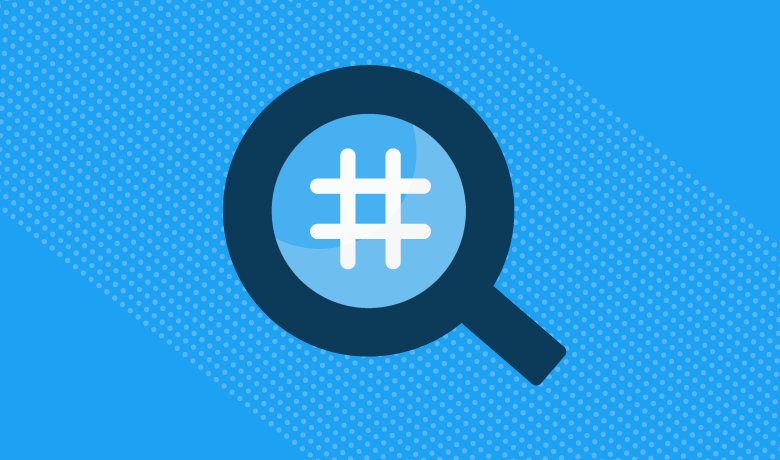

*Hashtags always hold some meaningful insights. They mostly express the essence of the whole tweet in one word or denotes the person or place or something about which the tweet talks about.*

In [ ]:
def get_hash_tags(df_series):
    """ Collects all hash tags from a given pandas series.
    
    Args:
        df_series (pd.Series): Pandas series object containing text data.
    
    Returns:
        hash_tags (list): List of hash tags from the pandas series.
    """
    
    hash_tags = []
    for text in df_series:
        hash_tags.extend(re.findall(r'#(\w+)', text))
        
    return hash_tags

In [ ]:
non_offensive_hashtags = get_hash_tags(train[train["label"]==0]["tweet"])
offensive_hashtags = get_hash_tags(train[train["label"]==1]["tweet"])

In [ ]:
# Word cloud of top mentioned hashtags in Non-offensive tweets
plot_word_cloud(non_offensive_hashtags)

In [ ]:
# Word cloud of top mentioned hashtags in Offensive tweets
plot_word_cloud(offensive_hashtags)

In [ ]:
# Count of each hashtags
non_offensive_hashtag_counts = Counter(non_offensive_hashtags)
offensive_hashtag_counts = Counter(offensive_hashtags)

In [ ]:
# Creating hashtag counts DataFrame for easy manipulation and visualization

non_offensive_hashtag_counts_df = pd.DataFrame.from_dict(non_offensive_hashtag_counts, orient="index").reset_index()
non_offensive_hashtag_counts_df.columns = ["hashtag", "count"]
non_offensive_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(non_offensive_hashtag_counts_df.head())

offensive_hashtag_counts_df = pd.DataFrame.from_dict(offensive_hashtag_counts, orient="index").reset_index()
offensive_hashtag_counts_df.columns = ["hashtag", "count"]
offensive_hashtag_counts_df.sort_values("count", ascending=False, inplace=True)
display(offensive_hashtag_counts_df.head())

In [ ]:
# Bar plot of top hashtag counts in Non-offensive tweets 
ax5 = non_offensive_hashtag_counts_df.head(50).plot.barh(y="count", figsize=(10, 14))
ax5.set(xlabel="( counts )", ylabel="( hashtag )")
ax5.set_yticklabels(non_offensive_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())
ax5.invert_yaxis()
plt.show()

* The Above visualisation shows the most frequent hashtags which were present in non-offensive tweets.

In [ ]:
# Bar plot of top hashtag counts in Offensive tweets 
ax6 = offensive_hashtag_counts_df.head(50).plot.barh(y="count", figsize=(10, 14), color="crimson")
ax6.set(xlabel="( counts )", ylabel="( hashtag )")
ax6.set_yticklabels(offensive_hashtag_counts_df.head(50).agg({"hashtag": lambda x: '#'+x}).values.flatten())
ax6.invert_yaxis()
plt.show()

* The Above visualisation shows the most frequent hashtags which were present in offensive tweets.

# **What proportion of tweets contains a hashtag?**

*We can even use just hashtags to classify our tweets. Even a piece of data matters a lot.*

In [ ]:
def count_rows_with_hashtag(df_series):
    """ Counts the number of rows containing at least one hashtag (#example).
    
    Args:
        df_series (pd.Series): Pandas series containing text data.
        
    Returns:
        count (int): Count of number of rows containing at least one hashtag.
    """
    
    count = 0
    for tweet in df_series:
        if re.search(r'#(\w+)', tweet):
            count+=1
    
    return count

In [ ]:
# Counts number of rows containing a hashtag
hashtag_tweet_count = count_rows_with_hashtag(train["tweet"])

train_rows, train_cols = train.shape

plt.figure(figsize=(6, 6))

# Creates pie chart
plt.pie(
    [hashtag_tweet_count, train_rows-hashtag_tweet_count],
    autopct = "%.2f%%",
    labels = ["With hashtag", "Without hashtag"],
    explode = [0, 0.06],
    shadow = True,
    colors = ["#1AC9E6", "#1DE4BD"]
)

plt.show()

* From our Pie chart, It is clear that most of the tweets contains a hashtag.
* These hashtags can help us classify the tweets more accurately.

# **Conclusion**

1. *The dataset contains three columns - "id", "label", "tweet".*
2. *Column "id" is not useful for classification.*
3. *Column "tweet" contains the tweets and column "label" contains their category.*
4. *There is no null values in the dataset.*
5. *Distribution of categories: 7.01 %  Offensive; 92.99 %  Not offensive.*
6. *Most of the tweets have around 5 to 20 tokens.*
7. *The number of tokens between 25th and 75th %ile (Interquartile range) of data ranges from 9 to 17 tokens, median being 13 tokens.* 
8. *Max length of any tweet in the dataset is less than 35 tokens.*
9. *We can see words like "racist", "black", "hate", "race" which are highly frequent in offensive tweets.*
10. *Most of the times tweets are about a specific person or an organisation.*
11. *Offensiveness in tweets mostly targets a specific person followed by organisations, religious, national or political parties.*
12. *Most frequent hashtags in Non-offensive tweets are "#love", "#positive", "#healthy", "#smile", "#thankful" which mostly reflects positivity.*
13. *Frequent hashtags in offensive tweets are "#black", "#hate", "#feminismiscancer", "#feminismisterrorism", "#hatred", "#race" which reflects offensiveness.*
14. *73.39 %  contains atleast one hashtag and only 26.61 %  does'nt contains a hashtag.*
15. *Hashtags can be helpful to improve model performance since they express what the tweet talks about most of the times.*